In [1]:
from typing import TypedDict, Annotated, List, Dict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_openai.chat_models.base import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

from dotenv import load_dotenv
from langsmith import Client
import json

import sqlite3
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

load_dotenv() 
client = Client() # langsmith 추적

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["랭그래프설계(5)"],  # Tag
)
memory = MemorySaver()

class RealEstateState(TypedDict): # 그래프의 상태를 정의하는 클래스
    real_estate_type: Annotated[str ,"부동산 유형 (예: 아파트, 상가)"]
    keywordlist: Annotated[List[Dict] ,"키워드 리스트"]
    messages: Annotated[list, add_messages]
    query_sql: Annotated[str ,"생성된 SQL 쿼리"]
    results: Annotated[List[Dict], "쿼리 결과"]
    answers: Annotated[List[str], "최종 답변 결과"]
    query_answer:Annotated[str, 'answer다듬기']

# Step 1: LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)

# Step 2: StateGraph 정의
workflow = StateGraph(RealEstateState)

In [2]:
def filter_node(state:RealEstateState) -> RealEstateState:
    print("[Filter Node] AI가 질문을 식별중입니다!!!!")
    system_prompt = """
    Classify if a given question is related to real estate. If the question is related to topics such as property transactions, rental conditions, location recommendations, or property features, return Pass. If it's not directly related to real estate, return Fail.

    # Output Format
    - Return Pass if the question is real estate-related, otherwise return Fail.

    # Examples
    - 입력: '서울 아파트 매매 가격이 어떻게 되나요?'
      출력: Pass

    - 입력: '이 동네 전세 시세 알려주세요'
      출력: Pass

    - 입력: '서울에서 월세 계약 조건이 어떻게 되나요?'
      출력: Pass

    - 입력: '서울 아파트 매매가 얼마인가요?'
      출력: Pass

    - 입력: '대치동에서 버스정류장과 지하철이 가장 가까운 곳으로 알려줘'
      출력: Pass

    - 입력: '여자 혼자 살기 좋은 곳 추천해줘'
      출력: Pass

    - 입력: '교통이 편리하고 저렴한 원룸 추천해줘'
      출력: Pass

    - 입력: '이 음식점이 맛있나요?'
      출력: Fail

    - 입력: '서울에서 가장 큰 공원이 어디인가요?'
      출력: Fail
    """
    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(state["messages"][-1].content)
    ])

    real_estate_type = response.content.strip()
    print("[Filter Node] AI가 질문을 식별했습니다.")
    return RealEstateState(real_estate_type=real_estate_type)

def fiter_router(state: RealEstateState):
    # This is the router
    real_estate_type = state["real_estate_type"]
    if real_estate_type == "Pass":
        return "Pass"
    else:
        return 'Fail'
    
def re_questions(state: RealEstateState) -> RealEstateState:
    print("=================================")
    print("""[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.
          부동산 관련 질문을 좀 더 자세하게 작성해주시면 답변드리겠습니다!!!""")
    new_question = input("새로운 부동산 질문을 입력해주세요: ")
    print("=================================")
    # 수정된 질문을 state에 업데이트
    return RealEstateState(messages=new_question)


def get_db_engine(db_path):
    """로컬 SQLite DB 파일과 연결된 엔진을 생성합니다."""
    try:
        # SQLite DB 파일과 연결
        connection = sqlite3.connect(db_path, check_same_thread=False)
        # SQLAlchemy 엔진 생성
        engine = create_engine(
            f"sqlite:///{db_path}",
            poolclass=StaticPool,
            connect_args={"check_same_thread": False}
        )
        return engine
    except Exception as e:
        print(f"데이터베이스 연결 중 오류 발생: {str(e)}")
        return None
    
    
# DB 파일 경로 지정
db_path = './data/real_estate_(1).db'
engine = get_db_engine(db_path)
db = SQLDatabase(
    engine,
    sample_rows_in_table_info=False  # 샘플 행 조회 비활성화
)

In [3]:
# def generate_query(state: RealEstateState) -> RealEstateState:
#     print("[generate_query] 열심히 데이터베이스 쿼리문을 작성중입니다...")
#     table = db.get_table_info(table_names=["addresses","sales", "rentals", "property_info", "property_locations","location_distances", "subway_stations"])
#     prompt = f"""
#     다음 데이터베이스 구조를 기반으로 사용자의 질문에 대한 SQL 쿼리를 생성해주세요:
    
#     테이블 및 주요 컬럼 설명:
#     {table}

#     거리 및 대중교통 관련 계산 규칙:
#     - **대중교통과 매물간의 거리 계산**: 테이블들을 활용해서 계산합니다.

#     주의사항:
#     1. 관련 조건은 SQL WHERE 절 형식으로 작성해주세요.
#     2. '최근 5년' 같은 상대적 시간 표현은 현재 날짜 기준으로 변환해주세요.
#     3. '추천할 만한', '인기 있는' 등의 표현은 적절히 해석하여 조건을 추가해주세요. 예: 'crime_rate < 5' 또는 'population_level = "높음"'.
#     4. 텍스트 검색에는 LIKE 또는 MATCH ... AGAINST를 활용하세요.
#     5. 여러 조건은 AND 또는 OR로 연결하세요.
#     6. 정렬, 그룹화 등이 필요한 경우 이를 추가로 명시하세요. 예: ORDER BY created_at DESC.
#     7. 매물들을 정렬할 때 우선순위는 위치(1순위), 가격(2순위) 순 입니다.
#     8. 쿼리만 작성하고 추가 설명은 하지 마세요.
#     9. rental_type 값은 다음과 같습니다:
#         - 'MONTHLY': 전세
#         - 'YEARLY': 월세
#     10. facilities는 영어로 쳐야지 나옵니다.
#         - pi.facilities LIKE '%ELEVATOR%' -> 엘리베이터
#         - pi.facilities LIKE '%aircon%' -> 에이컨, 에어콘
#     11. 매물번호도 함께 보여주세요 매물번호는 property_id입니다.
#     12. rentals 테이블에 price라는 컬럼이 없습니다. rentals 테이블에는 price 대신 deposit(보증금)과 monthly_rent(월세) 컬럼이 존재합니다.
#     13. 지하철역에 관한 정보는 addresses 테이블의 area_name 칼럼에 있습니다.
#         - addresses.area_name LIKE '%강남역%' -> 강남역
#     14. subway_stations 테이블에는 지하철역이 아닌 지하철이 몇호선인지가 담겨있습니다.
#     15. subway_stations 테이블은 지하철 호선을 묻지를 않는 이상 절대로 사용하지 않습니다.
#     16. "역세권"은 location_distances 테이블의 distance를 사용하면 됩니다.
#         사용방법:
#         - location_distances 테이블의 address_id를 활용해서 관련 역을 찾습니다.
#         - location_distances 테이블의 property_location_id를 활용해서 관련 매물을 찾습니다.
#         - location_distances 테이블의 distance는 단위가 m(미터)입니다.

#     사용자 질문: {state['messages'][-1].content}

#     SQL 쿼리 형식:
#     SELECT * FROM table_name WHERE condition1 AND condition2 ...;
#     """

#     response = llm.invoke([
#             SystemMessage(content="당신은 SQLite Database  쿼리를 생성하는 전문가입니다."),
#             HumanMessage(prompt)
#         ])
#     print('[generate_query]: 쿼리문을 생성했습니다!')
    
#     return RealEstateState(query_sql=response.content)

In [4]:
import json

def extract_keywords_based_on_db(state: RealEstateState) -> RealEstateState:
    system_prompt = """
    Extract relevant keywords from a user's question based on the database schema. Match the keywords to the following categories and their corresponding tables/columns:

    1. **Location**:
    - Table: `Location`
    - Columns: `sido`, `sigungu`, `dong`

    2. **Property Type**:
    - Table: `Property`
    - Column: `property_type` (e.g., apartment, villa, officetel)

    3. **Price**:
    - Tables: `Sale`, `Rental`
    - Columns: `price`, `deposit`, `monthly_rent`

    4. **Transaction Type**:
    - Tables: `Sale`, `Rental`
    - Columns: `rental_type` (e.g., 매매, 전세, 월세)

    5. **Property Features**:
    - Table: `Property`
    - Columns: `room_count`, `bathroom_count`, `parking_count`, `exclusive_area`, `floor`

    6. **User Preferences**:
    - Table: `User`
    - Columns: `desired_location`, `age`, `gender`

    7. **Cultural/Facilities**:
    - Tables: `Cultural Facility`, `Cultural Festival`
    - Columns: `facility_name`, `festival_name`

    8. **Safety and Crime Data**:
    - Table: `Crime Stats`
    - Columns: `crime_category`, `crime_rate`

    # Output Format
    Return the extracted keywords in JSON format with the following keys:
    - "Location"
    - "Property Type"
    - "Price"
    - "Transaction Type"
    - "Property Features"
    - "User Preferences"
    - "Cultural/Facilities"
    - "Safety and Crime Data"

    If a category is not mentioned, return "없음".

    # Examples
    - Input: "서울 강남구에 있는 3억 이하 전세 아파트 찾아줘"
    Output: {
        "Location": "서울 강남구",
        "Property Type": "아파트",
        "Price": "3억 이하",
        "Transaction Type": "전세",
        "Property Features": "없음",
        "User Preferences": "없음",
        "Cultural/Facilities": "없음",
        "Safety and Crime Data": "없음"
    }

    - Input: "용산구에서 안전한 주택 찾고 싶어요"
    Output: {
        "Location": "용산구",
        "Property Type": "주택",
        "Price": "없음",
        "Transaction Type": "없음",
        "Property Features": "없음",
        "User Preferences": "없음",
        "Cultural/Facilities": "없음",
        "Safety and Crime Data": "안전"
    }

    - Input: "화장실 2개, 방 3개 있는 집 알려줘"
    Output: {
        "Location": "없음",
        "Property Type": "없음",
        "Price": "없음",
        "Transaction Type": "없음",
        "Property Features": "화장실 2개, 방 3개",
        "User Preferences": "없음",
        "Cultural/Facilities": "없음",
        "Safety and Crime Data": "없음"
    }
    """

    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=state["messages"][-1].content)
    ])
    
    extracted_keywords = response.content.strip()
    result = json.loads(extracted_keywords)
    return RealEstateState(keywordlist=result)



In [5]:
base_prompt = """
다음 데이터베이스 구조를 기반으로 사용자의 질문에 대한 SQL 쿼리를 생성해주세요:

사용가능한 데이터 베이스 스키마:
{table}

주의사항:
1. 관련 조건은 SQL WHERE 절 형식으로 작성해주세요.
2. SQL 쿼리를 작성할 때는 명확하고 효율적이어야 합니다.
3. 결과는 최대 {top_k}개까지만 보여주세요.
4. 금액에 관련된 쿼리를 작성할 때는 쉼표(,)를 제거하고 숫자로 변환해야 합니다. 가능하다면, `WITH` 절 또는 서브쿼리를 사용하여 필드를 미리 변환하고 가독성을 높이세요.
5. 에러가 발생하면 원인을 설명하고 수정된 쿼리를 제시해주세요.
6. 텍스트 검색에는 LIKE 또는 MATCH ... AGAINST를 활용하세요.
7. 여러 조건은 AND 또는 OR로 연결하세요.
8. 정렬, 그룹화 등이 필요한 경우 이를 추가로 명시하세요. 예: ORDER BY created_at DESC.
9. 매물들을 정렬할 때 우선순위는 위치(1순위), 가격(2순위) 순 입니다.
10. 쿼리만 작성하고 추가 설명은 하지 마세요.
11. facilities는 영어로 쳐야지 나옵니다.
    - pi.facilities LIKE '%ELEVATOR%' -> 엘리베이터
    - pi.facilities LIKE '%aircon%' -> 에이컨, 에어콘
12. 매물번호도 함께 보여주세요 매물번호는 property_id입니다.

13. 지하철역에 관한 정보는 addresses 테이블의 area_name 칼럼에 있습니다.
    - addresses.area_name LIKE '%강남역%' -> 강남역
14. subway_stations 테이블에는 지하철역이 아닌 지하철이 몇호선인지가 담겨있습니다.
15. subway_stations 테이블은 지하철 호선을 묻는 것이 아닌 이상 사용하지마시오.
16. "역세권"은 location_distances 테이블의 distance를 사용하면 됩니다.
    - location_distances.distance <= 1000 -> "역세권"
17. property_type은 영어로 쳐야지 나옵니다.
    - pi.property_type LIKE '%APARTMENT%' -> 아파트
    - pi.property_type LIKE '%COMMERCIAL%' -> 상가
"""

rentals_prompt = """
18. rental_type 값은 다음과 같습니다:
    - 'MONTHLY': 전세
    - 'YEARLY': 월세
19. rentals 테이블에 price라는 컬럼이 없습니다. rentals 테이블에는 price 대신 deposit(보증금)과 monthly_rent(월세) 컬럼이 존재합니다.

### 예시 질문과 쿼리:

- 질문: "서울시 강남구 보증금 2000에 월세 70짜리 추천해줘"

```sql
SELECT 
    r.property_id,
    pi.description,
    pi.facilities,
    r.deposit AS "보증금",
    r.monthly_rent AS "월세비",
FROM rentals r
JOIN property_info pi ON r.property_id = pi.property_id
JOIN property_locations l ON pi.property_location_id = l.property_location_id
WHERE l.sigungu LIKE '%강남구%'
AND r.rental_type = 'YEARLY'
AND CAST(REPLACE(r.deposit, ',', '') AS INTEGER) <= 20000000
AND CAST(REPLACE(r.monthly_rent, ',', '') AS INTEGER) <= 700000;
'''

- 질문: "강남역 역세권 전세 10억 추천해줘"

```sql
SELECT DISTINCT
    r.property_id,
    pi.description,
    pi.facilities,
    r.deposit AS "보증금"
FROM rentals r
JOIN property_info pi ON r.property_id = pi.property_id
JOIN property_locations l ON pi.property_location_id = l.property_location_id
JOIN location_distances ld ON ld.property_location_id = pi.property_location_id
JOIN addresses a ON a.address_id = ld.address_id 
WHERE a.area_name LIKE '%강남역%'
  AND r.rental_type = 'MONTHLY'
  AND CAST(REPLACE(r.deposit, ',', '') AS INTEGER) <= 1000000000;
'''

사용자 질문: {user_query}
"""

sales_prompt = """

### 예시 질문과 쿼리

- 질문: "서울시 강서구 10억짜리 매물 찾아줘"

```sql
SELECT 
    s.property_id,
    pi.description,
    pi.facilities,
    s.price AS "가격"
FROM sales s
JOIN property_info pi ON s.property_id = pi.property_id
JOIN property_locations l ON pi.property_location_id = l.property_location_id
WHERE l.sigungu LIKE '%강서구%'
AND CAST(REPLACE(s.price, ',', '') AS INTEGER) <= 1000000000
'''

- 질문: "강동역 역세권 아파트 15억 추천해줘"

```sql
SELECT DISTINCT 
    s.property_id,
    pi.description,
    pi.facilities,
    s.price AS "가격"
FROM sales s
JOIN property_info pi ON s.property_id = pi.property_id
JOIN property_locations l ON pi.property_location_id = l.property_location_id
JOIN location_distances ld ON ld.property_location_id = pi.property_location_id
JOIN addresses a ON a.address_id = ld.address_id
WHERE a.area_name LIKE '%강동역%'
  AND CAST(REPLACE(s.price, ',', '') AS INTEGER) <= 1500000000;
'''

사용자 질문: {user_query}

"""

def generate_query(state: RealEstateState) -> RealEstateState:
    print("[generate_query] 열심히 데이터베이스 쿼리문을 작성중입니다...")

    if state['keywordlist'] == '매매':
        prompt = base_prompt + sales_prompt
        table = db.get_table_info(table_names=["addresses","sales","property_info", "property_locations","location_distances"])
        prompt = prompt.format(
            table = table,
            top_k=5,
            user_query=state['messages'][-1].content
        )
    else:
        prompt = base_prompt + rentals_prompt
        table = db.get_table_info(table_names=["addresses","rentals","property_info", "property_locations","location_distances"])
        prompt = prompt.format(
            table = table,
            top_k=5,
            user_query=state['messages'][-1].content
        )
    
    
    response = llm.invoke([
            SystemMessage(content="당신은 SQLite Database  쿼리를 생성하는 전문가입니다."),
            HumanMessage(prompt)
        ])
    print('[generate_query]: 쿼리문을 생성했습니다!')
    
    return RealEstateState(query_sql=response.content)

In [6]:
def clean_sql_response(state: RealEstateState) -> RealEstateState:
    print('[clean_sql_response]: 쿼리문을 다듬는 중 입니다.')
    
    # 'query_sql' 키는 항상 존재한다고 가정
    query_sql = state['query_sql']

    # 코드 블록(````sql ... `````) 제거
    if query_sql.startswith("```sql") and query_sql.endswith("```"):
        query_sql = query_sql[6:-3].strip()  # "```sql" 제거 후 앞뒤 공백 제거

    # SQL 문 끝에 세미콜론 추가 (필요시)
    if not query_sql.strip().endswith(";"):
        query_sql = query_sql.strip() + ";"
        
    print('[clean_sql_response]: 쿼리문 다듬기 끝.')
    # 상태 업데이트
    return RealEstateState(query_sql=query_sql)

In [7]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def run_query(state: RealEstateState) -> RealEstateState:
    
    tool = QuerySQLDataBaseTool(db=db)
    results = tool._run(state["query_sql"])

    if results == '':
        results = '결과값이 없습니다!!! 다시 질문해주세요!'
        return RealEstateState(results=results)

    return RealEstateState(results=results)

In [8]:
def generate_response(state: RealEstateState)-> RealEstateState:

    system_prompt = f"""
    당신은 부동산 추천 전문가이자 세계 지식을 갖춘 AI입니다. 
    주어진 정보와 세계 지식을 결합하여 아래 양식에 맞춰서 사용자의 질문에 답변해주세요.
    구분선 이후 간단한 추천이유도 적어줍니다.
    조회한 결과 매물 데이터 전부를 양식에 맞춰서 나열해줍니다.

    정보: {state['results']}


    ## 출력 양식:
    **매물번호**: {{property_id}}

    **특징**:
    {{특징}}

    ________________________

    **추천 이유**:
    {{추천 이유}}
    """

    user_prompt=f"""
    사용자의 질문: {state['messages'][-1].content}
    """

    response = llm.invoke([
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_prompt)
        ])
    
    output = response.content.strip()

    return RealEstateState(answers=output)

In [9]:
workflow.add_node("Filter Question", filter_node)
workflow.add_node('Re_Questions', re_questions)
workflow.add_node('Extract_keywords_based_on_db', extract_keywords_based_on_db)
workflow.add_node('Generate_Query', generate_query)
workflow.add_node('Clean_Sql_Response', clean_sql_response)
workflow.add_node('Run_Query', run_query)
workflow.add_node('Generate_Response', generate_response)

In [10]:
workflow.add_conditional_edges(
    "Filter Question",
    fiter_router,
    { 'Pass': "Extract_keywords_based_on_db", 'Fail': 'Re_Questions'}
)

In [11]:
workflow.add_edge(START, "Filter Question")
workflow.add_edge("Re_Questions", "Filter Question")
workflow.add_edge("Extract_keywords_based_on_db", "Generate_Query")
workflow.add_edge("Generate_Query", "Clean_Sql_Response")
workflow.add_edge("Clean_Sql_Response", "Run_Query")
workflow.add_edge("Run_Query", "Generate_Response")
workflow.add_edge("Generate_Response", END)

In [12]:
app = workflow.compile(checkpointer=memory)

In [13]:
result = app.invoke({'messages': '서울시 강남역에서 1000미터 이내 전세 10억 매물을 추천해줘'}, config=config)

[Filter Node] AI가 질문을 식별중입니다!!!!
[Filter Node] AI가 질문을 식별했습니다.
[generate_query] 열심히 데이터베이스 쿼리문을 작성중입니다...
[generate_query]: 쿼리문을 생성했습니다!
[clean_sql_response]: 쿼리문을 다듬는 중 입니다.
[clean_sql_response]: 쿼리문 다듬기 끝.


In [14]:
print(result['answers'])

**매물번호**: 6949640

**특징**:
◈ 전세 금액: 10억  
◈ 2025년 1월 입주 가능  
◈ 50평, 방 5개 욕실 2개  
◈ 대형 거실과 넓은 침실  
◈ 구조 좋은 남향  
◈ 관리비 약 40만원  
◈ 신논현역, 언주역 도보 10분 거리  
◈ 쾌적하고 조용한 1동 아파트  

________________________

**추천 이유**:
해당 매물은 강남역에서 도보로 접근 가능한 거리에 위치하고 있으며, 넓고 쾌적한 공간을 제공합니다. 방과 욕실도 다수 있어서 가족단위 거주에 적합합니다. 2025년 입주 가능으로, 시간적 여유도 있어 계획적으로 이사할 수 있습니다.


In [15]:
print(result['query_sql'])

SELECT DISTINCT
    r.property_id,
    pi.description,
    pi.facilities,
    r.deposit AS "보증금"
FROM rentals r
JOIN property_info pi ON r.property_id = pi.property_id
JOIN property_locations l ON pi.property_location_id = l.property_location_id
JOIN location_distances ld ON ld.property_location_id = pi.property_location_id
JOIN addresses a ON a.address_id = ld.address_id 
WHERE a.area_name LIKE '%강남역%'
  AND ld.distance <= 1000
  AND r.rental_type = 'MONTHLY'
  AND CAST(REPLACE(r.deposit, ',', '') AS INTEGER) <= 1000000000
ORDER BY l.sigungu, CAST(REPLACE(r.deposit, ',', '') AS INTEGER);


In [16]:
print(result['results'])

[(6949640, '상담 02-534-8949 / 문의 010-4355-0030\r\n\r\n◑ 매물 정보 ◑\r\n◈ 전세 금액: 10억 \r\n◈ 2025년 1월 입주 가능\r\n◈ 50평, 방 5개 욕실 2개 \r\n◈ 대형 거실과 넓은 침실\r\n◈ 구조 좋은 남향\r\n◈ 관리비 약 40만원\r\n◈ 신논현역, 언주역 도보 10분 거리\r\n◈ 쾌적하고 조용한 1동 아파트\r\n\r\n◐중개사 정보◑\r\n등록번호11650-2023-00068 (서초구)\r\n대표/공인중개사, 매경부동산자산관리사, 빌딩관리사1급 \r\n저희는 손님 유도 광고나 허위매물·과장 광고는 하지 않습니다.\r\n기타...', '{"aircon": null, "life": null, "security": null, "etc": null}', 980000000), (6949653, '상담 02-534-8949 / 문의 010-4355-0030\r\n\r\n\r\n◑ 매물 정보 ◑\r\n◈ 전세 금액: 8억 6,000만원\r\n◈ 즉시입주, 입주협의 가능\r\n◈ 34평, 방 3개 욕실 2개\r\n◈ 거실, 작은방 확장수리\r\n◈ 내부 올 수리로 컨디션 최고\r\n◈ 2개 화장실 올수리로 깨끗하고 깔끔\r\n◈ 보일러 교체로 따뜻한 집\r\n◈ 최고층 단독세대\r\n◈ 장기 거주 가능\r\n\r\n\r\n◐중개사 정보◑\r\n등록번호11650-2023-00068 (서초구)\r\n대표/공인중개사, 매경부동산자산관리사, 빌딩관리사1급 \r\n저희는 손님 유도 광고나...', '{"aircon": null, "life": null, "security": null, "etc": null}', 860000000)]


In [17]:
result['results'].split('(')

['[',
 "6949640, '상담 02-534-8949 / 문의 010-4355-0030\\r\\n\\r\\n◑ 매물 정보 ◑\\r\\n◈ 전세 금액: 10억 \\r\\n◈ 2025년 1월 입주 가능\\r\\n◈ 50평, 방 5개 욕실 2개 \\r\\n◈ 대형 거실과 넓은 침실\\r\\n◈ 구조 좋은 남향\\r\\n◈ 관리비 약 40만원\\r\\n◈ 신논현역, 언주역 도보 10분 거리\\r\\n◈ 쾌적하고 조용한 1동 아파트\\r\\n\\r\\n◐중개사 정보◑\\r\\n등록번호11650-2023-00068 ",
 '서초구)\\r\\n대표/공인중개사, 매경부동산자산관리사, 빌딩관리사1급 \\r\\n저희는 손님 유도 광고나 허위매물·과장 광고는 하지 않습니다.\\r\\n기타...\', \'{"aircon": null, "life": null, "security": null, "etc": null}\', 980000000), ',
 "6949653, '상담 02-534-8949 / 문의 010-4355-0030\\r\\n\\r\\n\\r\\n◑ 매물 정보 ◑\\r\\n◈ 전세 금액: 8억 6,000만원\\r\\n◈ 즉시입주, 입주협의 가능\\r\\n◈ 34평, 방 3개 욕실 2개\\r\\n◈ 거실, 작은방 확장수리\\r\\n◈ 내부 올 수리로 컨디션 최고\\r\\n◈ 2개 화장실 올수리로 깨끗하고 깔끔\\r\\n◈ 보일러 교체로 따뜻한 집\\r\\n◈ 최고층 단독세대\\r\\n◈ 장기 거주 가능\\r\\n\\r\\n\\r\\n◐중개사 정보◑\\r\\n등록번호11650-2023-00068 ",
 '서초구)\\r\\n대표/공인중개사, 매경부동산자산관리사, 빌딩관리사1급 \\r\\n저희는 손님 유도 광고나...\', \'{"aircon": null, "life": null, "security": null, "etc": null}\', 860000000)]']

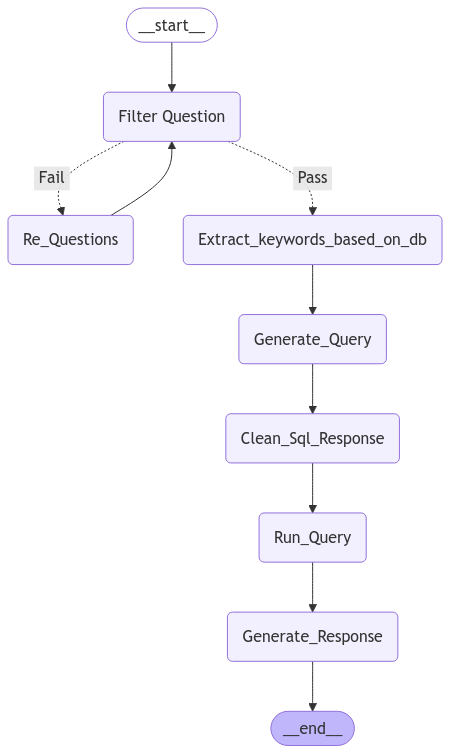

In [18]:
from IPython.display import Image, display

workflow_image = app.get_graph().draw_mermaid_png()
display(Image(workflow_image))